In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
from classifiers.datasets import IrisDataset
# for QASVM
from classifiers.quantum.qasvm import QASVM, NormQSVM
from classifiers.quantum.ansatz import Circuit9, sample_circuit
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator, StatevectorSimulator, Aer, QasmSimulator

In [4]:
ds = IrisDataset(feature_range=(-np.pi, np.pi), true_hot=0)
X, y = ds.sample(2**6, return_X_y=True)

In [5]:
backend = StatevectorSimulator(device='CPU', shots=2**13)
backend.options

Options(shots=8192, device='CPU', precision='double', executor=None, max_job_size=None, max_shot_size=None, zero_threshold=1e-10, validation_threshold=None, max_parallel_threads=None, max_parallel_experiments=None, max_parallel_shots=None, max_memory_mb=None, seed_simulator=None, fusion_enable=True, fusion_verbose=False, fusion_max_qubit=5, fusion_threshold=14, statevector_parallel_threshold=14)

In [6]:
_feature_map = Circuit9(X.shape[1], reps=1)
feature_map = _feature_map.copy()
for _ in range(2 - 1):
    feature_map.compose(_feature_map, inplace=True)

var_form = sample_circuit(15)(num_qubits=6, reps=5)
quantum_instance = QuantumInstance(backend=backend, shots=2**13)
qasvm = NormQSVM(
        X, y, lamda=1,
        quantum_instance=quantum_instance,
        var_form=var_form,
        feature_map=feature_map
    )
storage = CostParamStorage()
optimizer = tSPSA(maxiter=2**5, blocking=True, last_avg=16, callback=storage)

In [7]:
qasvm.cost_fn(qasvm.parameters)

0.4941355257148294

In [8]:
import qiskit.tools.jupyter
from qiskit.algorithms.optimizers import SPSA, ADAM
from tqdm.notebook import tqdm
MAXITER = 2**10

pbar = tqdm(total=MAXITER)

def callback(nfev, params, fval, stepsize, accepted):
    storage(nfev, parameters=params, cost=fval, step_size=stepsize, isaccepted=accepted)
    pbar.update()

optimizer = SPSA(maxiter=MAXITER, blocking=True, last_avg=16, callback=callback)
# optimizer = ADAM(snapshot_dir='./')

opt_result = optimizer.minimize(fun=qasvm.cost_fn, x0=qasvm.initial_point, jac=qasvm.grad_fn)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [9]:
print(opt_result)

{   'fun': 0.040174694660051274,
    'jac': None,
    'nfev': 3073,
    'nit': None,
    'njev': None,
    'x': array([-1.56472876,  2.59855177, -2.33426715,  0.33851011,  2.45094263,
        1.2882865 ,  3.12587804, -0.57830676,  2.6432059 ,  2.3190778 ,
        0.88254545, -1.01237409, -2.12377778, -0.21592798, -2.73249379,
        1.25568205,  2.14040463, -0.02059231, -1.53714043,  3.14998873,
        0.85116713,  2.11539627, -2.84584746,  0.35570974, -0.31693988,
        0.28039534,  3.46960393,  3.57825509, -1.06509618,  1.22323275])}


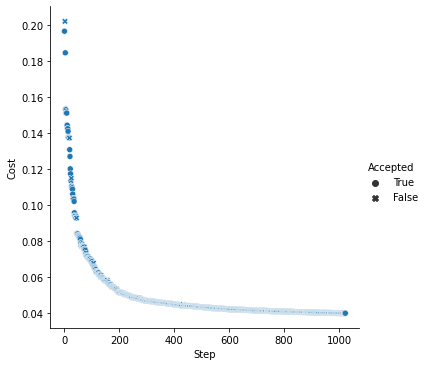

In [10]:
storage.plot()

In [11]:
qasvm.parameters = storage.last_avg(16)
qasvm.accuracy(X, y)

0.96875

In [25]:
from classifiers.quantum.qasvm import PseudoNormQSVM

pqasvm = PseudoNormQSVM(X, y, quantum_instance=quantum_instance, feature_map=feature_map, lamda=qasvm.lamda)
pstorage = CostParamStorage()

In [29]:
pqasvm.cost_fn(pqasvm.parameters)

0.17508276289179958

In [38]:
pbar = tqdm(total=10*MAXITER)

def pcallback(nfev, params, fval, stepsize, accepted):
    pstorage(nfev, parameters=params, cost=fval, step_size=stepsize, isaccepted=accepted)
    pbar.update()

poptimizer = SPSA(maxiter=10*MAXITER, blocking=True, last_avg=16, callback=pcallback)
# optimizer = ADAM(snapshot_dir='./')

popt_result = poptimizer.minimize(fun=pqasvm.cost_fn, x0=pqasvm.initial_point)
pbar.close()

  0%|          | 0/10240 [00:00<?, ?it/s]

In [39]:
print(popt_result)

{   'fun': 0.05178688441050265,
    'jac': None,
    'nfev': 30721,
    'nit': None,
    'njev': None,
    'x': array([ 2.17913971e+00, -1.31054254e-03,  4.76432120e-01, -2.39203582e-02,
        4.82090089e+00, -1.49852202e+00,  3.35600863e-03,  2.13149570e+00,
       -3.50781996e+00,  3.74396408e-01,  3.59592035e-01,  3.38285048e-02,
       -1.26211737e+00,  2.52957861e+00, -7.74974906e-01,  7.98401216e-01,
        3.86676537e+00, -1.28512243e+00,  9.39643074e-01,  2.13681129e+00,
        3.12044521e+00,  1.81099979e+00,  2.28253315e+00, -6.94399973e-03,
        1.10545853e+00,  3.58452911e+00,  2.78096031e+00,  7.61560507e-01,
        3.88092578e+00,  5.71192535e-03,  1.22644558e+00, -1.81739803e-01,
        1.87348852e-03,  1.58159485e+00,  2.13308268e+00,  3.37299003e+00,
        4.00005602e-01, -1.52611687e-03,  1.37608972e+00, -1.17021983e-03,
        2.66759647e+00, -1.18904930e+00,  9.93127714e-01,  3.15291372e+00,
       -1.10135324e+00, -9.22684128e-04, -5.20989465e-01, -1.05

In [41]:
pqasvm.parameters = pstorage.last_avg(16, True)
pqasvm.accuracy(X, y)

0.96875

In [42]:
import qiskit.tools.jupyter
%qiskit_version_table